## Assignment 2 - Convolution networks to image data 
**In this assignment, you will examine the relationship between training samples and the choice of training your model from scratch, versus using a pretrained convnet**.

# **Downloading the data**

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pavankumarpendela","key":"b273a0fb3739240e81238fb57d004069"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:03<00:00, 205MB/s]
100% 812M/812M [00:03<00:00, 225MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq test1.zip

In [6]:
!unzip -qq train.zip

## **# Question1.**
## Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?
# Copying images to training, validation, and test directories.

In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Initially taking 1000 samples for training set
make_subset("train", start_index=0, end_index=1000)
#500 samples for validation set
make_subset("validation", start_index=1000, end_index=1500)
#500 for test set
make_subset("test", start_index=1500, end_index=2000)

**Data preprocessing**

Using image_dataset_from_directory to read images

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [9]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [10]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [11]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [12]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [13]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## **Building the model**

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Fitting the model using a Dataset**

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 166s 3s/step - loss: 0.7239 - accuracy: 0.5160 - val_loss: 0.6843 - val_accuracy: 0.6090
Epoch 2/30
63/63 [==============================] - 164s 3s/step - loss: 0.7076 - accuracy: 0.5805 - val_loss: 0.6954 - val_accuracy: 0.5310
Epoch 3/30
63/63 [==============================] - 165s 3s/step - loss: 0.6602 - accuracy: 0.6190 - val_loss: 0.6158 - val_accuracy: 0.6900
Epoch 4/30
63/63 [==============================] - 164s 3s/step - loss: 0.6204 - accuracy: 0.6520 - val_loss: 0.6173 - val_accuracy: 0.6450
Epoch 5/30
63/63 [==============================] - 165s 3s/step - loss: 0.6113 - accuracy: 0.6860 - val_loss: 0.6110 - val_accuracy: 0.6520
Epoch 6/30
63/63 [==============================] - 162s 3s/step - loss: 0.5699 - accuracy: 0.7120 - val_loss: 0.5746 - val_accuracy: 0.7060
Epoch 7/30
63/63 [==============================] - 160s 3s/step - loss: 0.5498 - accuracy: 0.7475 - val_loss: 0.5978 - val_accuracy: 0.6780
Epoch 8/30
63

Displaying curves of loss and accuracy during training

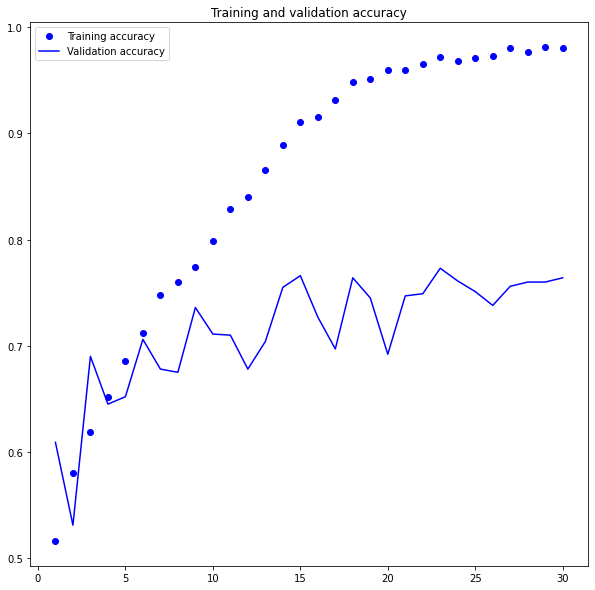

<Figure size 432x288 with 0 Axes>

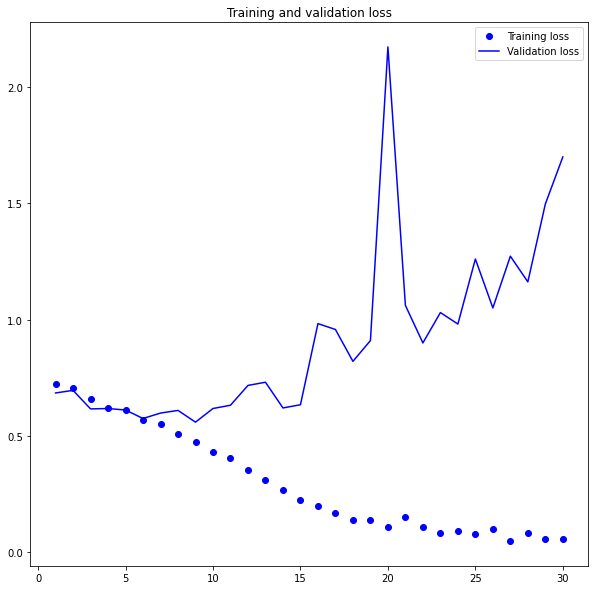

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [19]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 19s 593ms/step - loss: 0.6458 - accuracy: 0.7160
Test accuracy: 0.716


Here we got training accurracy as 98.05%, validation accuracy as 76.4% and test accuracy 71.6%

# **Question 2**

**Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?**
## **Using data augmentation**
**Define a data augmentation stage to add to an image model**

In [20]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Here I have increased training sample size to 1500 and keeping the validation and test sample size to 500 each as before
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [21]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Displaying some randomly augmented training images

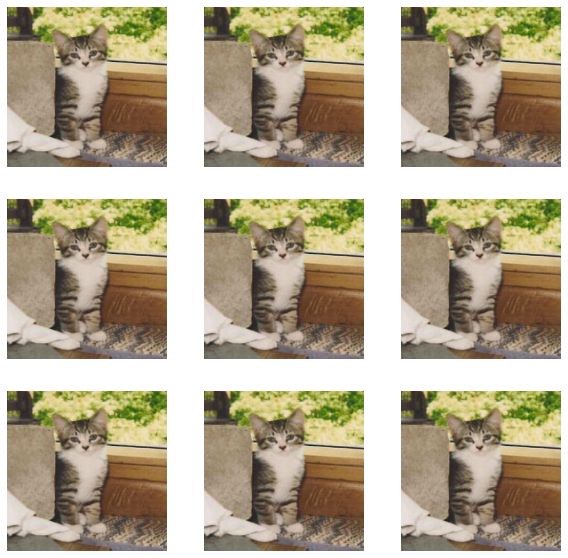

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [23]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 173s 3s/step - loss: 0.8823 - accuracy: 0.5125 - val_loss: 0.6918 - val_accuracy: 0.5320
Epoch 2/20
63/63 [==============================] - 170s 3s/step - loss: 0.7281 - accuracy: 0.5150 - val_loss: 0.6880 - val_accuracy: 0.5680
Epoch 3/20
63/63 [==============================] - 169s 3s/step - loss: 0.6878 - accuracy: 0.5620 - val_loss: 0.6675 - val_accuracy: 0.6160
Epoch 4/20
63/63 [==============================] - 168s 3s/step - loss: 0.6906 - accuracy: 0.6165 - val_loss: 0.6763 - val_accuracy: 0.5830
Epoch 5/20
63/63 [==============================] - 170s 3s/step - loss: 0.6709 - accuracy: 0.6345 - val_loss: 0.6105 - val_accuracy: 0.6430
Epoch 6/20
63/63 [==============================] - 170s 3s/step - loss: 0.6449 - accuracy: 0.6425 - val_loss: 0.6307 - val_accuracy: 0.6100
Epoch 7/20
63/63 [==============================] - 173s 3s/step - loss: 0.6208 - accuracy: 0.6665 - val_loss: 0.6214 - val_accuracy: 0.6720
Epoch 8/20
63

**Evaluating the model on the test set**

In [25]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 19s 582ms/step - loss: 0.5675 - accuracy: 0.7340
Test accuracy: 0.734


# We got training accuracy 75.15% and validation accuracy 74.9% and test accuracy 73.4%

# **Question 3**
**Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results**.

In [26]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#As increasing the sample size is always good than decreasing, here we're increasing the training the sample size to 2000
make_subset("train", start_index=0, end_index=2000)
#validation and test sample size 500 each
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 169s 3s/step - loss: 0.6963 - accuracy: 0.5020 - val_loss: 0.6929 - val_accuracy: 0.5080
Epoch 2/20
63/63 [==============================] - 172s 3s/step - loss: 0.6923 - accuracy: 0.5205 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
63/63 [==============================] - 169s 3s/step - loss: 0.6925 - accuracy: 0.5075 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 4/20
63/63 [==============================] - 169s 3s/step - loss: 0.6935 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/20
63/63 [==============================] - 170s 3s/step - loss: 0.6933 - accuracy: 0.4930 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
63/63 [==============================] - 170s 3s/step - loss: 0.6932 - accuracy: 0.4805 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/20
63/63 [==============================] - 171s 3s/step - loss: 0.6931 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 8/20
63

In [29]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 20s 598ms/step - loss: 0.6882 - accuracy: 0.5470
Test accuracy: 0.547


# Training accuracy of 54.8% and validation accuracy of 68.99% and test accuracy 54.7%

# **Question 4**
**Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.**
# Leveraging a pretrained model
# Feature extraction with a pretrained model
# **Instantiating the VGG16 convolutional base**

In [30]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [31]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [33]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [34]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 3s 44ms/step - loss: 14.1005 - accuracy: 0.9270 - val_loss: 5.2702 - val_accuracy: 0.9630
Epoch 2/20
63/63 [==============================] - 3s 45ms/step - loss: 3.9915 - accuracy: 0.9685 - val_loss: 16.5046 - val_accuracy: 0.9200
Epoch 3/20
63/63 [==============================] - 3s 45ms/step - loss: 3.2032 - accuracy: 0.9780 - val_loss: 4.1896 - val_accuracy: 0.9660
Epoch 4/20
63/63 [==============================] - 2s 39ms/step - loss: 1.1624 - accuracy: 0.9915 - val_loss: 4.2263 - val_accuracy: 0.9740
Epoch 5/20
63/63 [==============================] - 2s 39ms/step - loss: 0.8767 - accuracy: 0.9885 - val_loss: 6.0990 - val_accuracy: 0.9570
Epoch 6/20
63/63 [==============================] - 3s 43ms/step - loss: 0.5154 - accuracy: 0.9955 - val_loss: 3.6936 - val_accuracy: 0.9750
Epoch 7/20
63/63 [==============================] - 3s 42ms/step - loss: 0.3813 - accuracy: 0.9960 - val_loss: 4.6162 - val_accuracy: 0.9730
Epoch 8/20


**Plotting the results**

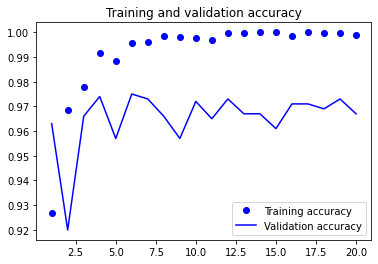

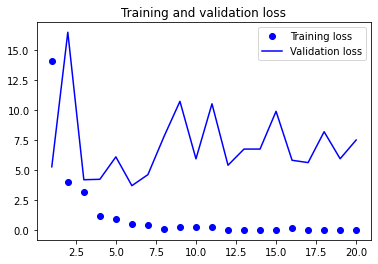

In [35]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Feature extraction together with data augmentation.

**Instantiating and freezing the VGG16 convolutional base** 

In [36]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [37]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [38]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Adding a data augmentation stage and a classifier to the convolutional base

In [39]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [40]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 917s 15s/step - loss: 17.9427 - accuracy: 0.8945 - val_loss: 28.1164 - val_accuracy: 0.8720
Epoch 2/10
63/63 [==============================] - 897s 14s/step - loss: 7.4731 - accuracy: 0.9375 - val_loss: 15.9808 - val_accuracy: 0.9200
Epoch 3/10
63/63 [==============================] - 891s 14s/step - loss: 5.1463 - accuracy: 0.9600 - val_loss: 3.7898 - val_accuracy: 0.9720
Epoch 4/10
63/63 [==============================] - 898s 14s/step - loss: 5.8257 - accuracy: 0.9560 - val_loss: 2.4793 - val_accuracy: 0.9790
Epoch 5/10
63/63 [==============================] - 900s 14s/step - loss: 5.2557 - accuracy: 0.9615 - val_loss: 1.8142 - val_accuracy: 0.9810
Epoch 6/10
63/63 [==============================] - 906s 14s/step - loss: 3.4667 - accuracy: 0.9700 - val_loss: 4.5922 - val_accuracy: 0.9710
Epoch 7/10
63/63 [==============================] - 903s 14s/step - loss: 3.2157 - accuracy: 0.9695 - val_loss: 2.8264 - val_accuracy: 0.9770
Epo

**Evaluating the model on the test set**

In [41]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 298s 9s/step - loss: 3.6271 - accuracy: 0.9750
Test accuracy: 0.975


# **Fine-tuning a pretrained model**

In [42]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [43]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [44]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 1009s 16s/step - loss: 1.2212 - accuracy: 0.9820 - val_loss: 3.5393 - val_accuracy: 0.9740
Epoch 2/10
63/63 [==============================] - 1024s 16s/step - loss: 1.2315 - accuracy: 0.9835 - val_loss: 2.6996 - val_accuracy: 0.9740
Epoch 3/10
63/63 [==============================] - 1026s 16s/step - loss: 0.9492 - accuracy: 0.9835 - val_loss: 2.1635 - val_accuracy: 0.9810
Epoch 4/10
63/63 [==============================] - 1027s 16s/step - loss: 0.7391 - accuracy: 0.9830 - val_loss: 2.1009 - val_accuracy: 0.9790
Epoch 5/10
63/63 [==============================] - 1017s 16s/step - loss: 0.5241 - accuracy: 0.9905 - val_loss: 2.0310 - val_accuracy: 0.9830
Epoch 6/10
63/63 [==============================] - 1015s 16s/step - loss: 0.4900 - accuracy: 0.9890 - val_loss: 2.6797 - val_accuracy: 0.9730
Epoch 7/10
63/63 [==============================] - 1008s 16s/step - loss: 0.4228 - accuracy: 0.9915 - val_loss: 1.4823 - val_accuracy: 0.9800

In [45]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 298s 9s/step - loss: 1.8071 - accuracy: 0.9800
Test accuracy: 0.980


# **Summary**
Initially I have taken a small convnet of 1000 trainng samples and validation and test sample size of 500 each and there is no optimization. So, the accuracy is just 71.6% due to overfitting. Later, we have introduced data augmentation,early stopping, dropout and the accuracy Dropped 54.7 %.

Pretrained model without augmentation A pretrained model gives more accuracy than the model which is built from scratch. Here we got validation accuracy of 96.7% which is far better than that we got from building a model from scratch.

Pretrained model with augmentation Here the validation accuracy slightly increased from 96.7% to 97.5%

Using predefined model with fine tuning gave 98.0% test accuracy.